In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [138]:
import numpy as np
from polyheight import extract_polyheights

# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)

safety_distance = 5
polygons, min_bounds = extract_polyheights(data, safety_distance=safety_distance)
north_offset, east_offset = min_bounds[:2].astype(int)
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
offset = np.array([north_offset, east_offset, 0])
offset_2D = offset[:2] # for 2D map

North offset = -321, east offset = -450


### Util function to plot grid, graph and path

In [140]:
import matplotlib.pyplot as plt
def show_path(grid, path, graph=None, show=True):
    plt.imshow(grid, cmap='Greys', origin='lower')
    if graph:
        # draw nodes
        for n1 in graph.nodes:
            plt.scatter(n1[1], n1[0], c='red')

        # draw edges
        for (n1, n2) in graph.edges:
            plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'black')
    # draw path
    path_pairs = zip(path[:-1], path[1:])
    for (n1, n2) in path_pairs:
        plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'green')

    if path:
        start, goal = path[0], path[-1]
        plt.scatter(start[1], start[0], c='green')
        plt.scatter(goal[1], goal[0], c='blue')
        
    plt.xlabel('NORTH')
    plt.ylabel('EAST')
    if show:
        plt.show()

# Define start and goal

In [141]:
# In grid coordinates
#start = (494, 462, 5)
#goal = (750., 370., 5)
start = (495, 465, 5)
goal = (629, 576, 5)

# 2.5D grid search space

Searching path from (495, 465, 5) to (629, 576, 5) (no offset represented)
Searching path from (495, 465, 5) to (629, 576, 5) (offset [0 0 0]) 
Found a path.
Path before pruning has length 155
Path after pruning has length 8


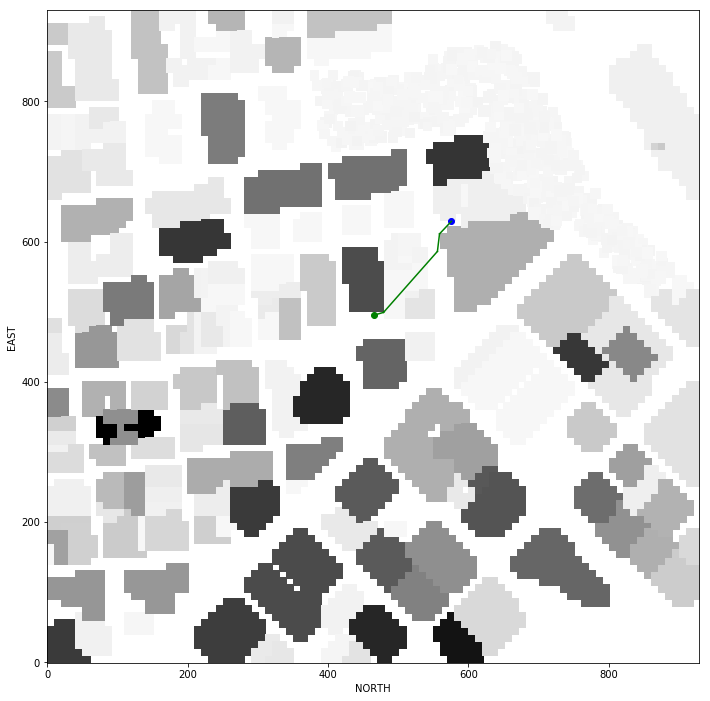

In [142]:
from search_space import GridSearchSpace, GraphSearchSpace
grid25 = GridBuilder(polygons).create_grid_25D()
gss = GridSearchSpace(grid25, np.array([0,0,0]))
path, cost = gss.search_path(start, goal)
plt.figure(figsize=(12,12))
show_path(grid25, path)

# Random sampling 2D graph

There are 600 nodes and 2394 edges
Searching path from (495, 465, 5) to (629, 576, 5) (no offset represented)
Searching path from (495.0, 465.0) to (629.0, 576.0) (offset [0 0])
Closest graph node to (495.0, 465.0): (482, 480)
Closest graph node to (629.0, 576.0): (627, 556)
Found a path.
Path before pruning has length 8
Path after pruning has length 8


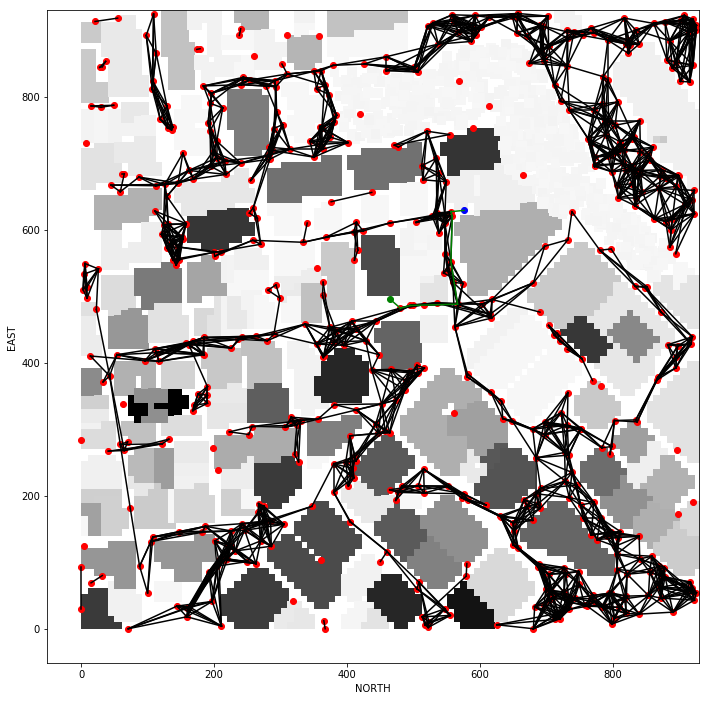

In [135]:
import networkx as nx
from graphbuilder import GraphBuilder
from search_space import GraphSearchSpace

graph_builder = GraphBuilder(np.array([0, 0, 0]), np.array([926, 926, 220]), polygons)
graph = graph_builder.create_sample_graph(n_samples=600, n_d=2, k=10)
north_offset, east_offset = min_bounds[:2].astype(int)
search_space = GraphSearchSpace(graph, offset=np.array([0, 0]))
path, cost = search_space.search_path(start, goal)

plt.figure(figsize=(12,12))
show_path(grid25, path, graph, show=False)
plt.show()

# Skeleton grid using medial axis

Searching path from (495, 465) to (629, 576) (no offset represented)
Searching path from (495, 465) to (629, 576) (offset [0 0]) height 1
[WARNING] Node is in an obstacle (495, 465)
Finding closest non obstacle node in grid to (495, 465): (490, 470)
[WARNING] Node is in an obstacle (629, 576)
Finding closest non obstacle node in grid to (629, 576): (626, 575)
Found a path.
Path before pruning has length 289
Path after pruning has length 154


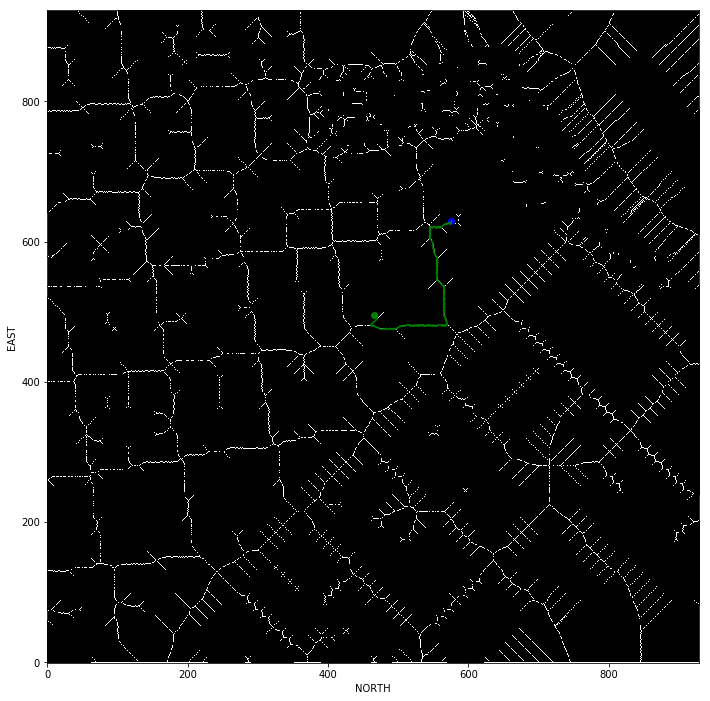

In [143]:
from gridbuilder import GridBuilder

skeleton = GridBuilder(polygons).create_grid_skeleton(altitude=5)
gss = GridSearchSpace(skeleton, offset=np.array([0,0]))
plt.figure(figsize=(12,12))
path, cost = gss.search_path(start, goal)
show_path(skeleton, path)

# Voronoi graph

There are 5274 nodes and 1274 edges
Searching path from (495, 465) to (629, 576) (no offset represented)
Searching path from (495, 465) to (629, 576) (offset [0 0]) height 1
[WARNING] Node is in an obstacle (495, 465)
Finding closest non obstacle node in grid to (495, 465): (490, 470)
[WARNING] Node is in an obstacle (629, 576)
Finding closest non obstacle node in grid to (629, 576): (626, 575)
Found a path.
Path before pruning has length 289
Path after pruning has length 154


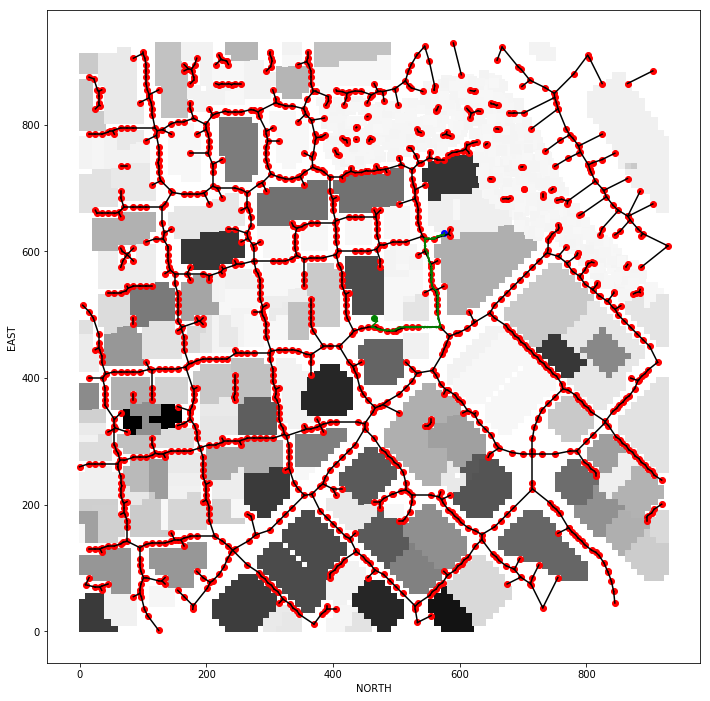

In [137]:
from graphbuilder import GraphBuilder
gb = GraphBuilder(np.array([0, 0, 0]), np.array([*grid25.shape, np.max(grid25).astype(int)])+1, polygons)
graph = gb.create_voronoi_graph(2, grid=grid25)
plt.figure(figsize=(12,12))
path, cost = gss.search_path(start, goal)
show_path(grid25, path, graph)

# RRT example

Creating local ss (495.0, 465.0, 5.0)
Creating RRT graph
Created RRT graph
Created search space


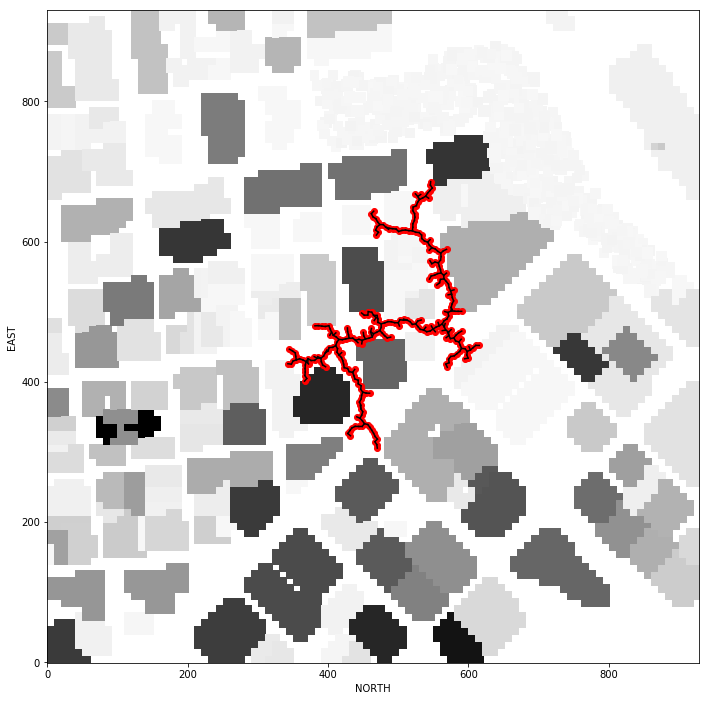

In [132]:
from search_space import RecedingHorizonSearchSpace
def get_local_rrt_search_space(current_position, horizon=300):
    current_position = tuple((np.array(current_position) - offset[:len(current_position)]).astype(float))
    print("Creating local ss", current_position)

    gb = GraphBuilder(np.array(current_position[:2])-horizon, np.array(current_position[:2])+horizon, polygons)
    print('Creating RRT graph')
    graph = gb.create_rrt_graph(current_position, num_vertices=300, dt=5)
    print('Created RRT graph')
    #all_nodes = np.array(list(graph.nodes))
    #min_values = np.amin(all_nodes, axis=0)
    #max_values = np.amax(all_nodes, axis=0)

    search_space = GraphSearchSpace(graph, offset=offset_2D)
    print('Created search space')
    return search_space


#get_rough_path = lambda s, g: [s, g]
#rhss = RecedingHorizonSearchSpace(get_local_rrt_search_space, get_rough_path)
#rhss.search_path((50, 90-38, 5), (750, 500, 5))


ss = get_local_rrt_search_space(np.array(start)+offset[:len(start)], 300)
plt.figure(figsize=(12,12))
show_path(grid25, [], ss.graph)

In [26]:
import numpy as np
def simulate(state, angle, v, dt):
    """Returns the next state."""
    x, y, theta = state
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += v * np.tan(angle) * dt
    return [x, y, theta]

angle = 5
v = 5
dt = 5
start = (10, 10, 0)
simulate(start, angle, v, dt)

[35.0, 10.0, -84.51287515616464]